## Loading the Data

### shit to fix
0. download and test all 3 models to get the best accuracy. Use the model definition from them them first but use ur dataset, trya dn recreate their results
1. check loss, check auroc/auprin, - per batch/epoch????? how frequent??
2. 


2. instatntiate ensemble code - run
3. instatntiate auprc, all the validation metrics

In [49]:
# from google.colab import drive
# drivsse.mount('/content/drive')
# %cd /content/drive/MyDrive/nus_cs_classes/CS5242/5242_proj
import sys 
import os 
sys.path.append(os.path.abspath('..')) 

In [50]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, Subset, RandomSampler
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from sklearn.model_selection import train_test_split
from numpy.random import RandomState
import torch.nn as nn
import zipfile
import os
import random

metadata = pd.read_csv('../meta_data.csv')
# generate mixoe classes = 40
dropped_classes = 40

# generate sploit of 5 leave out classifiers, each leaving out 40
leave_out = {}
class_range = np.arange(start= 1, stop = 201)
ran_state = RandomState(5242)
ran_state.shuffle(class_range)
print(class_range)

for splits in range(200//dropped_classes):
    leave_out[splits] = class_range[(splits)*dropped_classes:(splits+1)*dropped_classes]

[185   2 145  55 164 130 136  26 100 179  17 193  37  99 121 134  95  31
 167  24 105 119  34 135 159  15 198 113 116 176  74  51  86 125 114 151
   8   1 170  30  16 171  91 109 127  25  50  93  36 131  75  77  70  41
 182  58  65 148 196  38 104  67  64  11 111  89 156 155  60   4 143  61
 195 158 115 123 188 154 152 177  80  57  84 102 138  52  73 173 120  46
  23  48  69 112 187  13 180  54  83 126 168 107 110 129 163 153  97  21
  63  33  87  90  39  28  88 190  44 174 133  76  32 172 199 122  45 124
 165 197  22  66  14   5 183  20  68  47 106 137 157 118 181   6  49 160
 132  19 144 189 192  40  85   3 146  18 149  12  94 140  79  29 147 194
  72  27  42 186 108 103  96  43 169 166  35  62 117  78 200  59 162  81
 128   9 150  98  56   7 175  71  82 142  53 184 191  10 161  92 101 141
 178 139]


### auroc update test

In [51]:
from torcheval.metrics import BinaryAUROC

metric = BinaryAUROC()

input = torch.tensor([0.1, 0.5, 0.7, 0.8])
target = torch.tensor([1, 0, 1, 1])

metric.update(input,target)
metric.compute()


input = torch.tensor([1, 1, 1, 0])
target = torch.tensor([1, 1, 1, 0])
metric.update(input,target)
metric.compute()


tensor(0.9167, dtype=torch.float64)

In [52]:
from torcheval.metrics import BinaryAUROC
from utils.utils import AP

metric = BinaryAUROC()

input = torch.tensor([1, 1, 1, 0, 0.1, 0.5, 0.7, 0.8])
target = torch.tensor([1, 1, 1, 0, 1, 0, 1, 1])
metric.update(input,target)
metric.compute()



tensor(0.9167, dtype=torch.float64)

In [53]:
from utils.utils import AP
metric = AP()

input = torch.tensor([1, 1, 1, 0, 0.1, 0.5, 0.7, 0.8])
target = torch.tensor([1, 1, 1, 0, 1, 0, 1, 1])
metric_dict = {'auroc': BinaryAUROC(),
                'auprin': AP(),
                'auprout': AP()}

for metric in metric_dict:
            metric_dict[metric].update(input, target)

In [54]:
for metric in metric_dict:
    metric_dict[metric].update(input, target)

In [55]:
## testing compute
auroc = metric_dict['auroc']

In [62]:
history = {'test': [torch.rand(10)]}

In [63]:
for key in history:
    history[key] = [metric.cpu() for metric in history[key]]

In [12]:
## test concat
temp = torch.rand(10)
temp.concat(torch.Tensor([2,3,4]))

AttributeError: 'Tensor' object has no attribute 'concat'

In [26]:
## testing condition and mask

labels = torch.rand(60)
mask = [labels[example].item() > 0.5 for example in range(labels.shape[0])]
id_out = labels[mask]
id_labels = labels[mask]
mask

[True,
 False,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 True,
 False,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 False,
 True,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 False,
 False,
 False,
 True,
 False]

In [29]:
inv_mask = not mask
print(inv_mask)

False


In [36]:
torch.Tensor([not boolean for boolean in mask]) ### t/f can be converted to 1s and 0s, 

tensor([0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1.,
        0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1.,
        0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0.,
        0., 1., 1., 1., 0., 1.])

In [7]:
leave_out       

{0: array([185,   2, 145,  55, 164, 130, 136,  26, 100, 179,  17, 193,  37,
         99, 121, 134,  95,  31, 167,  24, 105, 119,  34, 135, 159,  15,
        198, 113, 116, 176,  74,  51,  86, 125, 114, 151,   8,   1, 170,
         30]),
 1: array([ 16, 171,  91, 109, 127,  25,  50,  93,  36, 131,  75,  77,  70,
         41, 182,  58,  65, 148, 196,  38, 104,  67,  64,  11, 111,  89,
        156, 155,  60,   4, 143,  61, 195, 158, 115, 123, 188, 154, 152,
        177]),
 2: array([ 80,  57,  84, 102, 138,  52,  73, 173, 120,  46,  23,  48,  69,
        112, 187,  13, 180,  54,  83, 126, 168, 107, 110, 129, 163, 153,
         97,  21,  63,  33,  87,  90,  39,  28,  88, 190,  44, 174, 133,
         76]),
 3: array([ 32, 172, 199, 122,  45, 124, 165, 197,  22,  66,  14,   5, 183,
         20,  68,  47, 106, 137, 157, 118, 181,   6,  49, 160, 132,  19,
        144, 189, 192,  40,  85,   3, 146,  18, 149,  12,  94, 140,  79,
         29]),
 4: array([147, 194,  72,  27,  42, 186, 108, 103,  

### generate ID annotations and OOD annotations csv files

In [8]:
# removing dropped classes, dropping aug img
metadata = pd.read_csv('../meta_data.csv')

# generate col for is_oe_image, 0 for ID, 1 for OOD
df = {}

for split in leave_out:
    df[split] = {}
    leave_out_condition = metadata["class_id"].isin(leave_out[split])
    leave_in_condition = np.invert(leave_out_condition)
    df[split]['ood'] = metadata.loc[leave_out_condition]
    df[split]['id'] = metadata.loc[leave_in_condition]

# extract ood_df and id_df as annotations.csv
# ood_df = metadata[metadata["is_oe_image"] == 1]
# id_df = metadata[metadata["is_oe_image"] == 0]

# # checking that isoeimage done correctly
# metadata.loc[metadata["is_oe_image"] == 1] == ood_df

In [9]:
df[0]['id']

,image_id,image_name,class_id,class_name,is_training_image,bounding_x,bounding_y,bounding_width,bounding_height,augmented_image_name
120,121,003.Sooty_Albatross/Sooty_Albatross_0038_1065.jpg,3,003.Sooty_Albatross,1,196.0,96.0,222.0,147.0,./augmented_images/003.Sooty_Albatross/Sooty_A...
121,122,003.Sooty_Albatross/Sooty_Albatross_0031_1066.jpg,3,003.Sooty_Albatross,1,102.0,128.0,396.0,148.0,./augmented_images/003.Sooty_Albatross/Sooty_A...
122,123,003.Sooty_Albatross/Sooty_Albatross_0001_1071.jpg,3,003.Sooty_Albatross,1,105.0,133.0,168.0,283.0,./augmented_images/003.Sooty_Albatross/Sooty_A...
123,124,003.Sooty_Albatross/Sooty_Albatross_0016_1075.jpg,3,003.Sooty_Albatross,1,169.0,41.0,180.0,249.0,./augmented_images/003.Sooty_Albatross/Sooty_A...
124,125,003.Sooty_Albatross/Sooty_Albatross_0043_1076.jpg,3,003.Sooty_Albatross,1,1.0,134.0,316.0,345.0,./augmented_images/003.Sooty_Albatross/Sooty_A...
...,...,...,...,...,...,...,...,...,...,...
11783,11784,200.Common_Yellowthroat/Common_Yellowthroat_00...,200,200.Common_Yellowthroat,1,89.0,95.0,354.0,250.0,./augmented_images/200.Common_Yellowthroat/Com...
11784,11785,200.Common_Yellowthroat/Common_Yellowthroat_00...,200,200.Common_Yellowthroat,0,157.0,62.0,184.0,219.0,./augmented_images/200.Common_Yellowthroat/Com...
11785,11786,200.Common_Yellowthroat/Common_Yellowthroat_00...,200,200.Common_Yellowthroat,0,190.0,102.0,198.0,202.0,./augmented_images/200.Common_Yellowthroat/Com...
11786,11787,200.Common_Yellowthroat/Common_Yellowthroat_00...,200,200.Common_Yellowthroat,1,3.0,20.0,408.0,307.0,./augmented_images/200.Common_Yellowthroat/Com...


In [7]:
df[0]['ood']

,image_id,image_name,class_id,class_name,is_training_image,bounding_x,bounding_y,bounding_width,bounding_height,augmented_image_name
0,1,001.Black_footed_Albatross/Black_Footed_Albatr...,1,001.Black_footed_Albatross,0,60.0,27.0,325.0,304.0,./augmented_images/001.Black_footed_Albatross/...
1,2,001.Black_footed_Albatross/Black_Footed_Albatr...,1,001.Black_footed_Albatross,1,139.0,30.0,153.0,264.0,./augmented_images/001.Black_footed_Albatross/...
2,3,001.Black_footed_Albatross/Black_Footed_Albatr...,1,001.Black_footed_Albatross,0,14.0,112.0,388.0,186.0,./augmented_images/001.Black_footed_Albatross/...
3,4,001.Black_footed_Albatross/Black_Footed_Albatr...,1,001.Black_footed_Albatross,1,112.0,90.0,255.0,242.0,./augmented_images/001.Black_footed_Albatross/...
4,5,001.Black_footed_Albatross/Black_Footed_Albatr...,1,001.Black_footed_Albatross,1,70.0,50.0,134.0,303.0,./augmented_images/001.Black_footed_Albatross/...
...,...,...,...,...,...,...,...,...,...,...
11663,11664,198.Rock_Wren/Rock_Wren_0003_189167.jpg,198,198.Rock_Wren,1,70.0,67.0,271.0,224.0,./augmented_images/198.Rock_Wren/Rock_Wren_000...
11664,11665,198.Rock_Wren/Rock_Wren_0100_189426.jpg,198,198.Rock_Wren,0,136.0,91.0,211.0,134.0,./augmented_images/198.Rock_Wren/Rock_Wren_010...
11665,11666,198.Rock_Wren/Rock_Wren_0021_189175.jpg,198,198.Rock_Wren,1,84.0,82.0,270.0,236.0,./augmented_images/198.Rock_Wren/Rock_Wren_002...
11666,11667,198.Rock_Wren/Rock_Wren_0026_189181.jpg,198,198.Rock_Wren,1,21.0,95.0,254.0,243.0,./augmented_images/198.Rock_Wren/Rock_Wren_002...


In [8]:
### renaming class ids for ID data, ood data is not class specific
# rewrite class from 1 to 160

# generate counters, array holding
for split in df:
    for id_ood in df[split]:
        current_class_arr = df[split][id_ood]['class_id'].unique()
        if id_ood == 'ood':
            future_class_arr = -np.ones(len(current_class_arr))
        else:
            future_class_arr = np.arange(len(current_class_arr)) ###### class labels must span from 0 to 159
        
        replace_dict = {current_class_arr[i]:future_class_arr[i] for i in range(len(current_class_arr))}
        df[split][id_ood]['class_id'].replace(replace_dict, inplace=True)

/var/folders/bp/tngprtnj69n40h91d0tl3y7r0000gn/T/ipykernel_71008/2229984945.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[split][id_ood]['class_id'].replace(replace_dict, inplace=True)
/var/folders/bp/tngprtnj69n40h91d0tl3y7r0000gn/T/ipykernel_71008/2229984945.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[split][id_ood]['cl

In [9]:
df[0]['id']

,image_id,image_name,class_id,class_name,is_training_image,bounding_x,bounding_y,bounding_width,bounding_height,augmented_image_name
120,121,003.Sooty_Albatross/Sooty_Albatross_0038_1065.jpg,0,003.Sooty_Albatross,1,196.0,96.0,222.0,147.0,./augmented_images/003.Sooty_Albatross/Sooty_A...
121,122,003.Sooty_Albatross/Sooty_Albatross_0031_1066.jpg,0,003.Sooty_Albatross,1,102.0,128.0,396.0,148.0,./augmented_images/003.Sooty_Albatross/Sooty_A...
122,123,003.Sooty_Albatross/Sooty_Albatross_0001_1071.jpg,0,003.Sooty_Albatross,1,105.0,133.0,168.0,283.0,./augmented_images/003.Sooty_Albatross/Sooty_A...
123,124,003.Sooty_Albatross/Sooty_Albatross_0016_1075.jpg,0,003.Sooty_Albatross,1,169.0,41.0,180.0,249.0,./augmented_images/003.Sooty_Albatross/Sooty_A...
124,125,003.Sooty_Albatross/Sooty_Albatross_0043_1076.jpg,0,003.Sooty_Albatross,1,1.0,134.0,316.0,345.0,./augmented_images/003.Sooty_Albatross/Sooty_A...
...,...,...,...,...,...,...,...,...,...,...
11783,11784,200.Common_Yellowthroat/Common_Yellowthroat_00...,159,200.Common_Yellowthroat,1,89.0,95.0,354.0,250.0,./augmented_images/200.Common_Yellowthroat/Com...
11784,11785,200.Common_Yellowthroat/Common_Yellowthroat_00...,159,200.Common_Yellowthroat,0,157.0,62.0,184.0,219.0,./augmented_images/200.Common_Yellowthroat/Com...
11785,11786,200.Common_Yellowthroat/Common_Yellowthroat_00...,159,200.Common_Yellowthroat,0,190.0,102.0,198.0,202.0,./augmented_images/200.Common_Yellowthroat/Com...
11786,11787,200.Common_Yellowthroat/Common_Yellowthroat_00...,159,200.Common_Yellowthroat,1,3.0,20.0,408.0,307.0,./augmented_images/200.Common_Yellowthroat/Com...


In [10]:
df[0]['ood']

,image_id,image_name,class_id,class_name,is_training_image,bounding_x,bounding_y,bounding_width,bounding_height,augmented_image_name
0,1,001.Black_footed_Albatross/Black_Footed_Albatr...,-1,001.Black_footed_Albatross,0,60.0,27.0,325.0,304.0,./augmented_images/001.Black_footed_Albatross/...
1,2,001.Black_footed_Albatross/Black_Footed_Albatr...,-1,001.Black_footed_Albatross,1,139.0,30.0,153.0,264.0,./augmented_images/001.Black_footed_Albatross/...
2,3,001.Black_footed_Albatross/Black_Footed_Albatr...,-1,001.Black_footed_Albatross,0,14.0,112.0,388.0,186.0,./augmented_images/001.Black_footed_Albatross/...
3,4,001.Black_footed_Albatross/Black_Footed_Albatr...,-1,001.Black_footed_Albatross,1,112.0,90.0,255.0,242.0,./augmented_images/001.Black_footed_Albatross/...
4,5,001.Black_footed_Albatross/Black_Footed_Albatr...,-1,001.Black_footed_Albatross,1,70.0,50.0,134.0,303.0,./augmented_images/001.Black_footed_Albatross/...
...,...,...,...,...,...,...,...,...,...,...
11663,11664,198.Rock_Wren/Rock_Wren_0003_189167.jpg,-1,198.Rock_Wren,1,70.0,67.0,271.0,224.0,./augmented_images/198.Rock_Wren/Rock_Wren_000...
11664,11665,198.Rock_Wren/Rock_Wren_0100_189426.jpg,-1,198.Rock_Wren,0,136.0,91.0,211.0,134.0,./augmented_images/198.Rock_Wren/Rock_Wren_010...
11665,11666,198.Rock_Wren/Rock_Wren_0021_189175.jpg,-1,198.Rock_Wren,1,84.0,82.0,270.0,236.0,./augmented_images/198.Rock_Wren/Rock_Wren_002...
11666,11667,198.Rock_Wren/Rock_Wren_0026_189181.jpg,-1,198.Rock_Wren,1,21.0,95.0,254.0,243.0,./augmented_images/198.Rock_Wren/Rock_Wren_002...


In [11]:
df[0]['id'].loc[df[0]['id']['class_id'] == 199, 'class_id']

Series([], Name: class_id, dtype: int64)

In [12]:
## for some split 0, splitting id data into train and test
chosen_split = 0
id_df = df[chosen_split]['id']
ood_df = df[chosen_split]['ood']

id_df_train = id_df[id_df['is_training_image'] == 1]
id_df_test = id_df[id_df['is_training_image'] == 0]
id_df_test, id_df_val = train_test_split(id_df_test, test_size=0.2, random_state=42)

ood_df_train = ood_df[ood_df['is_training_image'] == 1]
ood_df_test = ood_df[ood_df['is_training_image'] == 0]

In [13]:
id_df

,image_id,image_name,class_id,class_name,is_training_image,bounding_x,bounding_y,bounding_width,bounding_height,augmented_image_name
120,121,003.Sooty_Albatross/Sooty_Albatross_0038_1065.jpg,0,003.Sooty_Albatross,1,196.0,96.0,222.0,147.0,./augmented_images/003.Sooty_Albatross/Sooty_A...
121,122,003.Sooty_Albatross/Sooty_Albatross_0031_1066.jpg,0,003.Sooty_Albatross,1,102.0,128.0,396.0,148.0,./augmented_images/003.Sooty_Albatross/Sooty_A...
122,123,003.Sooty_Albatross/Sooty_Albatross_0001_1071.jpg,0,003.Sooty_Albatross,1,105.0,133.0,168.0,283.0,./augmented_images/003.Sooty_Albatross/Sooty_A...
123,124,003.Sooty_Albatross/Sooty_Albatross_0016_1075.jpg,0,003.Sooty_Albatross,1,169.0,41.0,180.0,249.0,./augmented_images/003.Sooty_Albatross/Sooty_A...
124,125,003.Sooty_Albatross/Sooty_Albatross_0043_1076.jpg,0,003.Sooty_Albatross,1,1.0,134.0,316.0,345.0,./augmented_images/003.Sooty_Albatross/Sooty_A...
...,...,...,...,...,...,...,...,...,...,...
11783,11784,200.Common_Yellowthroat/Common_Yellowthroat_00...,159,200.Common_Yellowthroat,1,89.0,95.0,354.0,250.0,./augmented_images/200.Common_Yellowthroat/Com...
11784,11785,200.Common_Yellowthroat/Common_Yellowthroat_00...,159,200.Common_Yellowthroat,0,157.0,62.0,184.0,219.0,./augmented_images/200.Common_Yellowthroat/Com...
11785,11786,200.Common_Yellowthroat/Common_Yellowthroat_00...,159,200.Common_Yellowthroat,0,190.0,102.0,198.0,202.0,./augmented_images/200.Common_Yellowthroat/Com...
11786,11787,200.Common_Yellowthroat/Common_Yellowthroat_00...,159,200.Common_Yellowthroat,1,3.0,20.0,408.0,307.0,./augmented_images/200.Common_Yellowthroat/Com...


## Custom datasets for id and ood

In [14]:
# ## generating open ood dataset classes for left out classes

# from torch.utils.data import Dataset
# from torchvision.io import read_image, ImageReadMode
# from PIL import Image
# from torchvision.transforms.functional import crop

# class IDDataset(Dataset):

#     """
#     Contains ID dataset for train and validate
#     """

#     ######################## edit from here #############
#     def __init__(self, annotations_file, img_dir, transform=None, bbox = False, target_transform=None):
#         super().__init__()
#         self.img_labels = annotations_file # modified since loading metadata to load dataset
#         self.img_dir = img_dir
#         self.transform = transform
#         self.target_transform = target_transform
#         self.num_classes = self.img_labels['class_id'].nunique()
#         self.bbox = False

#         ## code in bounding boxes for use later on ########

#         if bbox == True: # generate series
#             self.bbox = True
#             self.bbox_y = annotations_file['bounding_y'].values
#             self.bbox_x = annotations_file['bounding_x'].values
#             self.bbox_height = annotations_file['bounding_height'].values
#             self.bbox_width = annotations_file['bounding_width'].values
    
#     def __len__(self):
#         return len(self.img_labels)

#     def __getitem__(self, idx):
#         img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 1]) # image name stored in 1st row
#         image = read_image(img_path)

#         # cropping
#         if self.bbox:
#             image = crop(image, int(self.bbox_y[idx]), int(self.bbox_x[idx]), int(self.bbox_height[idx]), int(self.bbox_width[idx]))

#         # check for greyscale , convert to rgb if so
#         if image.shape[0] == 1:
#             image = read_image(img_path, mode= ImageReadMode.RGB)

#         label = self.img_labels.iloc[idx, 2]
#         if self.transform:
#             image = self.transform(image)
#         if self.target_transform:
#             label = self.target_transform(label)
#         return image, label




In [15]:
# ## argparse 0. argparser - epochs, modes, set size, beta, m fix 0.4. 

# import argparse

# parser = argparse.ArgumentParser(description="Efficient Net")
# parser.add_argument("--epoch", type = int, default=30,
#                     help="epochs")
# parser.add_argument("--data", type=str,  default="norm",
#                     help = "data volume")
# parser.add_argument("--mode", type=str, default="norm",
#                     help = "mode")
# args = parser.parse_args()


In [16]:
# from torch.utils.data import ConcatDataset

In [17]:
# from torch.utils.data import ConcatDataset

# ### defining transformations

# # defining diff transforms, moved some transforms here
# transform = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

# train_transform = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.RandomRotation(degrees=45),
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

# # taking test_transfrom from sx

# test_transform = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

# train_transform_more = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.RandomRotation(degrees=45),
#     transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), shear=(-5, 5, -5, 5)),
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

# # defining image directories


# img_directory = "/Users/xy/Downloads/data/CUB_200_2011/CUB_200_2011/images" ######## change here for nscc ########
# ####### be sure to replace with /home/users/nus/e1144115/scratch/CUB_200_2011/CUB_200_2011/images/
# ## /home/users/nus/e1144115/scratch/CUB_200_2011/CUB_200_2011/images/
# ## /Users/xy/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Implementations/Data/CUB_200_2011/CUB_200_2011/images/
# # /content/drive/MyDrive/nus_cs_classes/CS5242/CUB_200_2011/CUB_200_2011/images/
# # pls remember to put backslashes

# ### defining dataloaders, 

# ###### creating datasets ######
# train_dataset_aug = IDDataset(id_df_train, img_directory, train_transform, bbox=True) # original with cropping
# train_dataset_augnocrop = IDDataset(id_df_train, img_directory, train_transform) ## no crop
# train_dataset_augmore = IDDataset(id_df_train, img_directory, train_transform_more, bbox=True) ### added aug
# train_dataset_noaug = IDDataset(id_df_train, img_directory, transform) ## no crop

# test_dataset_aug = IDDataset(id_df_test, img_directory, test_transform, bbox=True)
# test_dataset_augnocrop = IDDataset(id_df_test, img_directory, test_transform)
# test_dataset_augmore = IDDataset(id_df_test, img_directory, test_transform, bbox=True)
# test_dataset_noaug = IDDataset(id_df_test, img_directory, test_transform)

# val_dataset_aug = IDDataset(id_df_val, img_directory, test_transform, bbox=True)
# val_dataset_augnocrop = IDDataset(id_df_val, img_directory, test_transform)
# val_dataset_augmore = IDDataset(id_df_val, img_directory, test_transform, bbox=True)
# val_dataset_noaug = IDDataset(id_df_val, img_directory, test_transform)

# oe_dataset_aug = IDDataset(ood_df_train, img_directory, train_transform, bbox=True) # original with cropping
# oe_dataset_augnocrop = IDDataset(ood_df_train, img_directory, train_transform) ## no crop
# oe_dataset_augmore = IDDataset(ood_df_train, img_directory, train_transform_more, bbox=True) ### added aug
# oe_dataset_noaug = IDDataset(ood_df_train, img_directory, transform) ## no crop

# oeval_dataset_aug = IDDataset(ood_df_test, img_directory, test_transform, bbox=True)
# oeval_dataset_augnocrop = IDDataset(ood_df_test, img_directory, test_transform)
# oeval_dataset_augmore = IDDataset(ood_df_test, img_directory, test_transform, bbox=True)
# oeval_dataset_noaug = IDDataset(ood_df_test, img_directory, test_transform)


# # past ver of saving oe dataset
# # oe_dataset = IDDataset(ood_df_train, img_directory, train_transform) 
# # oe_dataset_norm = IDDataset(ood_df_train, img_directory, transform) 
# # oe_dataset = ConcatDataset([oe_dataset, oe_dataset_norm])


# ###### FULL ########
# # train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# # test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
# # val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

# # oe_loader = DataLoader(oe_dataset, batch_size=32, shuffle=True)
# # oeval_loader = DataLoader(oeval_dataset, batch_size=32, shuffle=True)

# # quick ood loss test


# #### continue from here ##### - transfer to ipynb
# # past ver of saving oe dataset
# # oe_dataset = IDDataset(ood_df_train, img_directory, train_transform) 
# # oe_dataset_norm = IDDataset(ood_df_train, img_directory, transform) 
# # oe_dataset = ConcatDataset([oe_dataset, oe_dataset_norm])

# train_dataset = ConcatDataset([train_dataset_aug, train_dataset_augnocrop, train_dataset_augmore, train_dataset_noaug][:1]) 
# test_dataset = ConcatDataset([test_dataset_aug, test_dataset_augnocrop, test_dataset_augmore, test_dataset_noaug][:1])
# val_dataset = ConcatDataset([val_dataset_aug, val_dataset_augnocrop, val_dataset_augmore, val_dataset_noaug][:1])
# oe_dataset = ConcatDataset([oe_dataset_aug, oe_dataset_augnocrop, oe_dataset_augmore, oe_dataset_noaug][:1]) 
# oeval_dataset = ConcatDataset([oeval_dataset_aug, oeval_dataset_augnocrop, oeval_dataset_augmore, oeval_dataset_noaug][:1])
# final_val_dataset = ConcatDataset([oeval_dataset, val_dataset, test_dataset])
# print(f"len of train_Dataset: {len(train_dataset)}, len of test_dataset {len(test_dataset)}, len of val_dataset: {len(val_dataset)}, len of oe_dataset:{len(oe_dataset)}, len of oeval_dataset:{len(oeval_dataset)}, len of final val mix:{len(final_val_dataset)}")

# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
# oe_loader = DataLoader(oe_dataset, batch_size=16, shuffle=True)
# oeval_loader = DataLoader(oeval_dataset, batch_size=16, shuffle=True)
# final_val_loader = DataLoader(final_val_dataset, batch_size=64, shuffle=True)
# print(f"len of train_loader: {len(train_loader)}, len of test_datalaoder {len(test_loader)}, len of val_datalaoder: {len(val_loader)}, len of oe_datalaoder:{len(oe_loader)}, len of oeval_loader:{len(oeval_loader)}, len of final val mix:{len(final_val_loader)}")

### checking for greyscale images

In [18]:
# batch_count = 0
# for batch in train_loader:
#     print(batch_count)
#     img, label = batch
#     iter_count = 0
#     for img in img:
#         print(img.shape)
#         print(iter_count)
#         iter_count+=1
#     batch_count+=1

## checking direct import functions

[185   2 145  55 164 130 136  26 100 179  17 193  37  99 121 134  95  31
 167  24 105 119  34 135 159  15 198 113 116 176  74  51  86 125 114 151
   8   1 170  30  16 171  91 109 127  25  50  93  36 131  75  77  70  41
 182  58  65 148 196  38 104  67  64  11 111  89 156 155  60   4 143  61
 195 158 115 123 188 154 152 177  80  57  84 102 138  52  73 173 120  46
  23  48  69 112 187  13 180  54  83 126 168 107 110 129 163 153  97  21
  63  33  87  90  39  28  88 190  44 174 133  76  32 172 199 122  45 124
 165 197  22  66  14   5 183  20  68  47 106 137 157 118 181   6  49 160
 132  19 144 189 192  40  85   3 146  18 149  12  94 140  79  29 147 194
  72  27  42 186 108 103  96  43 169 166  35  62 117  78 200  59 162  81
 128   9 150  98  56   7 175  71  82 142  53 184 191  10 161  92 101 141
 178 139]
len of train_Dataset: 19180, len of test_dataset 14892, len of val_dataset: 3724, len of oe_dataset:4796, len of oeval_dataset:4560, len of final val mix:23176
len of train_loader: 300, l

/Users/xy/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Implementations/CS5242-Bird-Species-Recognition/data/data.py:124: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[split][id_ood]['class_id'].replace(replace_dict, inplace=True)
/Users/xy/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Implementations/CS5242-Bird-Species-Recognition/data/data.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyd

test, test, mmmmmmmmmmmmmmmmmmm
dict_keys(['train', 'test', 'val', 'oe', 'oeval', 'final_val'])


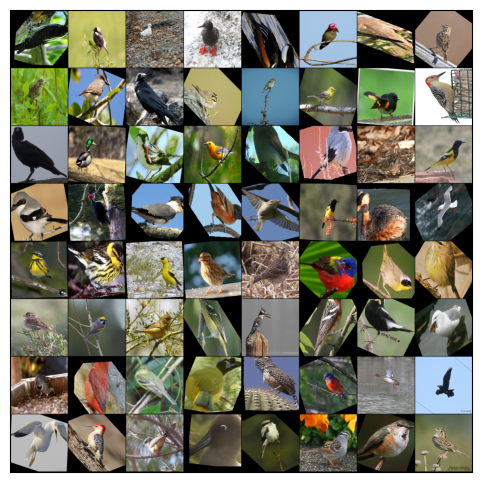

In [19]:
### testing data.py functions
from data.data import get_annotations_file, get_dataset_dict, get_dataloader_dict
from data.data import IDDataset

df_chosen = get_annotations_file()
dataset_dict = get_dataset_dict(df_chosen, 4)
dataloader_dict = get_dataloader_dict(dataset_dict)
print(dataloader_dict.keys())

Label:  0
torch.Size([3, 224, 224])


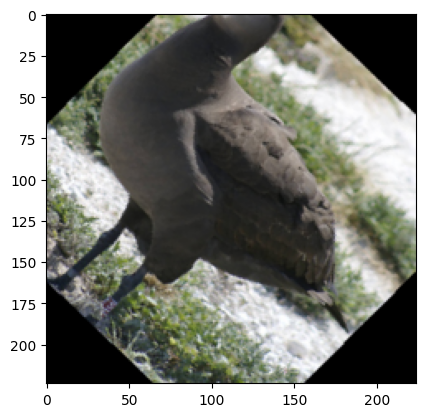

In [ ]:
import matplotlib.pyplot as plt

def show_example(img, label):
    print('Label: ', label)
    print(img.shape)
    plt.imshow(img.permute(1, 2, 0))

img, label = dataset_dict['train_dataset'][10]
show_example(img, label)

In [33]:
########## CONTINUE MOVING CODE HERE ######### - check howto org this so i can get dataloaders.....google for some file formats...and architectrures...

######### TO DO ########
## checl util functions for aupr/auprin/auprout test - under utils
### use jupyter to test functions
### define train.py and use that to call functions 
### adding in argparser

## Split Training Dataset into train and validation

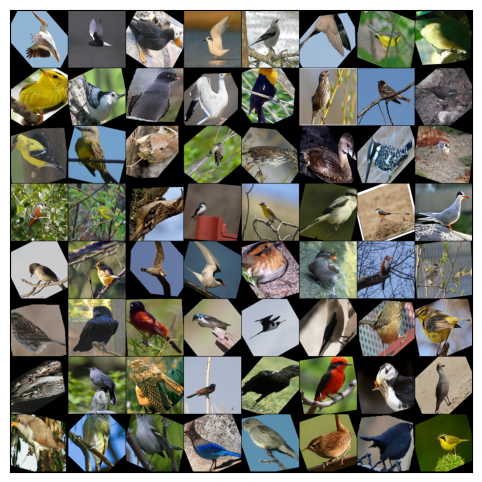

In [38]:
#### utils ####

import torchvision.utils as vutils

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(vutils.make_grid(images, nrow=8).permute(1, 2, 0))
        break
show_batch(dataloader_dict['train'])

######### to add in training loop #####
## avg functio

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)

# # soft CE for soft labels
# class SoftCE(nn.Module):
#     def __init__(self, reduction="mean"):
#         super().__init__()
#         self.reduction = reduction

#     def forward(self, logits, soft_targets):
#         preds = logits.log_softmax(dim=-1)
#         assert preds.shape == soft_targets.shape

#         loss = torch.sum(-soft_targets * preds, dim=-1)

#         if self.reduction == "mean":
#             return torch.mean(loss)
#         elif self.reduction == "sum":
#             return torch.sum(loss)
#         elif self.reduction == "none":
#             return loss
#         else:
#             raise ValueError("Reduction type '{:s}' is not supported!".format(self.reduction))


# # author of mixoe defined accuracy
# def accuracy_author(output, target, topk=(1,)):
#     """Computes the accuracy over the k top predictions for the specified values of k"""
#     with torch.no_grad():
#         maxk = max(topk)
#         batch_size = target.size(0)

#         _, pred = output.topk(maxk, 1, True, True)
#         pred = pred.t()
#         correct = pred.eq(target.view(1, -1).expand_as(pred))

#         res = []
#         for k in topk:
#             correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
#             res.append(correct_k.mul_(100.0 / batch_size).item())
#         return res

##### include extra validation calculations here
diff = [0, 1]
def Tpr95(X1, Y1):
    #calculate the falsepositive error when tpr is 95%
    total = 0.0
    fpr = 0.0
    for delta in diff:
        delta = float(delta)
        tpr = np.sum(np.sum(X1 >= delta)) / float(len(X1))
        error2 = np.sum(np.sum(Y1 > delta)) / float(len(Y1))
        if tpr <= 0.9505 and tpr >= 0.9495:
            fpr += error2
            total += 1
    fprBase = fpr/total

    return fprBase

def auprIn(X1, Y1):
    #calculate the AUPR
    precisionVec = []
    recallVec = []
    auprBase = 0.0
    recallTemp = 1.0
    for delta in diff:
        delta = float(delta)
        tp = np.sum(np.sum(X1 >= delta)) / float(len(X1))
        fp = np.sum(np.sum(Y1 >= delta)) / float(len(Y1))
        if tp + fp == 0: continue
        precision = tp / (tp + fp)
        recall = tp
        precisionVec.append(precision)
        recallVec.append(recall)
        auprBase += (recallTemp-recall)*precision
        recallTemp = recall
    auprBase += recall * precision

    return auprBase

def auprOut(X1, Y1):
    #calculate the AUPR
    auprBase = 0.0
    recallTemp = 1.0
    for delta in diff[::-1]:
        delta = float(delta)
        fp = np.sum(np.sum(X1 < delta)) / float(len(X1))
        tp = np.sum(np.sum(Y1 < delta)) / float(len(Y1))
        if tp + fp == 0: continue
        precision = tp / (tp + fp)
        recall = tp
        auprBase += (recallTemp-recall)*precision
        recallTemp = recall
    auprBase += recall * precision
        
    return auprBase

## EfficientNetB0 Transfer Learning Model Creation

In [39]:
import torch
from torch import nn
from torchvision.models import efficientnet_b0
from torch.distributions.beta import Beta
import torch.nn.functional as F

## efficient net b4 ahs 19mil vs b05mil

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()

    def training_step(self, batch):
        raise NotImplementedError

    def validation_step(self, batch):
        raise NotImplementedError

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss']))

class EfficientNetModel(BaseModel):
    def __init__(self, num_classes):
        super().__init__()
        self.network = efficientnet_b0(pretrained=True)
        self.num_classes = num_classes
        self.beta = 0.5

        # # Freeze all the parameters of the model
        # for param in self.network.parameters():
        #     param.requires_grad = False

        # # Unfreeze the last three layers
        # for param in list(self.network.parameters())[-3:]:
        #     param.requires_grad = True

        # Find the last linear layer in the classifier
        last_linear_layer = None
        for layer in reversed(self.network.classifier):
            if isinstance(layer, nn.Linear):
                last_linear_layer = layer
                break

        # Check if a linear layer was found
        if last_linear_layer is not None:
            num_ftrs = last_linear_layer.in_features
        else:
            raise ValueError("No linear layer found in classifier")

        # Add custom layers
        self.network.classifier = nn.Sequential(
            nn.Linear(num_ftrs, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, xb):
        return self.network(xb)

    def training_step(self, batch, batch_ood, device, mode = "OOD"):

        """
        mode can be "normal" or "OOD"
        run inference, generate losses, output losses
        """

        # generate prediction first, normal image and labels to device
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)

        images_ood, labels_ood = batch_ood
        images_ood = images_ood.to(device)
        labels_ood = labels_ood.to(device)

        if mode == "normal":
          out = self(images)                  #[bs]
          loss = F.cross_entropy(out, labels) # Calculate loss

          return loss

        elif mode == "OOD":

          """
          requires running on normal inference and OE MIX
          """

          ##### ID LOSS #######
          out_id = self(images) # [b, num_class]
          print(f"output_id.shape = f{out_id.shape}")
          id_loss = F.cross_entropy(out_id, labels)

          ### overall loss ######
          # ref: https://github.com/YU1ut/Ensemble-of-Leave-out-Classifiers/blob/master/eloc_solver.py#L63

          E_id = -torch.mean(torch.sum(F.log_softmax(out_id, dim=1) * F.softmax(out_id, dim=1), dim=1))

          output_ood = self(images_ood)
          print(f"output_ood.shape = f{output_ood.shape}")

          E_ood = -torch.mean(torch.sum(F.log_softmax(output_ood, dim=1) * F.softmax(output_ood, dim=1), dim=1))

          loss = F.cross_entropy(out_id, labels) + self.beta * torch.clamp(0.4 + E_id - E_ood, min=0)

          return loss, id_loss

    def validation_step(self, batch, device):
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)

        # init ground truth, pred prob vairables
        gts = [] # ground truth labels
        probs = [] # predicted prob
        diff = [0, 1] # accummulated differences 

        out = self(images)                    # Generate predictions
        print(out.shape)
        pred_prob = F.softmax(out, dim = 1)   # softmaxin

        for example in range(len(pred_prob)):
            gts.append(labels[example].item())
            probs.append(pred_prob[example])

        # init id and ood predicted softmax probabilities
        id_birds = []
        ood_birds = []

        for i in range(len(gts)):
            gt = gts[i]
            prob = probs[i]
            if gt >= 0:
                id_birds.append(torch.max(prob))
            else:
                ood_birds.append(torch.max(prob))
            diff.append(torch.max(prob)+10e-5)
        diff = sorted(list(set(diff))) # lowest scores should be OODs
        id_birds, ood_birds = np.array(id_birds), np.array(ood_birds)

        #calculate the AUROC
        aurocBase = 0.0
        fprTemp = 1.0
        for delta in diff:
            delta = float(delta)
            tpr = np.sum(np.sum(id_birds >= delta)) / float(len(id_birds))
            fpr = np.sum(np.sum(ood_birds >= delta)) / float(len(ood_birds))
            aurocBase += (-fpr+fprTemp)*tpr
            fprTemp = fpr
        aurocBase += fpr * tpr
        auroc = aurocBase

        # gettpr95, get auprin, aupr out
        auprin = auprIn(id_birds, ood_birds)
        auprout= auprOut(id_birds, ood_birds)
        

        # is_best = auroc > self.best_prec1
        # self.best_prec1 = max(auroc, self.best_prec1)

        # self.save_checkpoint({
        #     'epoch': epoch,
        #     'state_dict': self.model.state_dict(),
        #     'best_prec1': self.best_prec1,
        #     'opt' : self.opt.state_dict(),
        # }, is_best, checkpoint=self.args.checkpoint)

        # calculate accuracy for ID data

        mask = [labels[example].item() > 0 for example in range(len(pred_prob))]
        id_out = out[mask]
        id_labels = labels[mask]

        loss = F.cross_entropy(id_out, id_labels)   # Calculate loss
        acc = accuracy(id_out, id_labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc, 'auroc': auroc, 'auprin': auprin, 'auprout':auprout}


In [40]:
temp = torch.rand(160)


In [42]:
# simple mask indexing test
temp = torch.rand(160)
mask = [temp[example].item() > 0.9 for example in range(len(temp))]
temp[mask]

tensor([0.9505, 0.9307, 0.9509, 0.9758, 0.9858, 0.9983, 0.9750, 0.9377, 0.9776,
        0.9435, 0.9925, 0.9667, 0.9229, 0.9607, 0.9428])

## Training the Model

In [43]:
import numpy as np

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
### check if gpu available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model = EfficientNetModel(160).to(device)

def fit(epochs, lr, train_loader, val_loader, oe_loader, optimizer, mode = "OOD"):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'auroc':[],
               'auprin': [], 'auprout': [], 'tpr95':[]}
    optimizer = optimizer(model.parameters(), lr)

    # # defining some functions to be used later

    # losses = AverageMeter('Loss', ':.4e')
    # id_losses = AverageMeter('ID Loss', ':.4e')
    # mixed_losses = AverageMeter('Mixed Loss', ':.4e')
    # top1 = AverageMeter('Acc@1', ':6.2f')
    # top5 = AverageMeter('Acc@5', ':6.2f')

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        train_accs = []
        print("Starting epoch ", epoch+1, " of ", epochs)
        counter = 1
        
        # iterating thru batches
        for batch, batch_ood in zip(train_loader, oe_loader): #### consider tqdm....
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)
                        
            inputs_ood, labels_ood = batch_ood
            inputs_ood = inputs_ood.to(device)
            labels_ood = labels_ood.to(device)
            
            # Compute predictions and losses
            outputs = model(inputs)
            loss, id_loss = model.training_step(batch, batch_ood, device, mode="OOD")
            train_losses.append(loss.item())
            train_losses.append(id_loss.item())
            # train_losses.append(mixed_loss.item())

            
            # acc1, acc5 = accuracy_author(outputs, labels, topk=(1, 5))
            # losses.update(loss.item(), inputs.size(0))
            # id_losses.update(id_loss.item(), inputs.size(0))
            # # mixed_losses.update(mixed_loss.item(), inputs.size(0))
            # top1.update(acc1, inputs.size(0))
            # top5.update(acc5, inputs.size(0))

            # Compute train accuracy
            _, preds = torch.max(outputs, 1)
            acc = torch.sum(preds == labels.data) / len(labels)
            train_accs.append(acc.item())
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            counter+=1
        # Record training loss and accuracy
        history['train_loss'].append(np.mean(train_losses))
        history['train_acc'].append(np.mean(train_accs))

        # Validation phase
        model.eval()
        val_losses = []
        val_accs = []
        auroc = []
        auprin_ls = []
        auprout_ls = []
        tpr95_ls = []
        with torch.no_grad():
            for batch in val_loader:
                inputs, labels = batch
                inputs = inputs.to(device)
                labels = labels.to(device)
                # Compute predictions and losses
                loss_dict = model.validation_step(batch, device)
                val_losses.append(loss_dict['val_loss'].item())
                val_accs.append(loss_dict['val_acc'].item())
                auroc.append(loss_dict['auroc'].item())
                auprin_ls.append(loss_dict['auprin'].item())
                auprout_ls.append(loss_dict['auprout'].item())
                # tpr95_ls.append(loss_dict['tpr95'].item())
        # Record validation loss and accuracy
        history['val_loss'].append(np.mean(val_losses))
        history['val_acc'].append(np.mean(val_accs))
        history['auroc'].append(np.mean(auroc))
        history['auprin'].append(np.mean(auprin_ls))
        history['auprout'].append(np.mean(auprout_ls))
        # history['tpr95'].append(np.mean(auprin_ls))

        print(f'Epoch {epoch+1}/{epochs}, train loss: {np.mean(train_losses):.4f}, val loss: {np.mean(val_losses):.4f}, train acc: {np.mean(train_accs):.4f}, val acc: {np.mean(val_accs):.4f}, auroc: {np.mean(auroc):.4f}, auprin: {np.mean(auprin_ls):.4f}, auprout: {np.mean(auprout_ls):.4f}')
        #  tpr95: {np.mean(tpr95_ls):.4f}
    return history

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [44]:
num_epochs = 1
opt_func = torch.optim.Adam
lr = 0.001
## maybe train laoder...../ anyth to do with classes, check if dropped classes can still be allocated

In [45]:
dataloader_dict['oe']

In [46]:
history = fit(num_epochs, lr, dataloader_dict['train'], dataloader_dict['final_val'], dataloader_dict['oe'], opt_func, mode="normal")

Starting epoch  1  of  1
output_id.shape = ftorch.Size([64, 160])
output_ood.shape = ftorch.Size([16, 160])
output_id.shape = ftorch.Size([64, 160])
output_ood.shape = ftorch.Size([16, 160])
output_id.shape = ftorch.Size([64, 160])
output_ood.shape = ftorch.Size([16, 160])
output_id.shape = ftorch.Size([64, 160])
output_ood.shape = ftorch.Size([16, 160])


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

    ax1.plot(history['train_loss'], label='train loss')
    ax1.plot(history['val_loss'], label='validation loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(history['train_acc'], label='train accuracy')
    ax2.plot(history['val_acc'], label='validation accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.savefig('history_comb.png')

plot_history(history)

NameError: name 'history' is not defined

In [ ]:
import matplotlib.pyplot as plt

def plot_auroc(history):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

    ax1.plot(history['auroc'], label='auroc')
    ax1.plot(history['auprin'], label='auprin')
    ax1.plot(history['auprout'], label='auprout')

    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    plt.tight_layout()
    plt.savefig('history_auroc.png')

plot_auroc(history)

## Test the Model

In [ ]:
def test_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0

    # init top1, top5
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)

            # # defining top k accuracy from author
            # acc1, acc5 = accuracy_author(output, y, topk=(1, 5))
            # top1.update(acc1, x.size(0))
            # top5.update(acc5, x.size(0))

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))

test_model(model, test_loader, device)

In [ ]:
def evaluate_model(model, test_dataloader):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():

        # init ground truth, pred prob vairables
        gts = [] # ground truth labels
        probs = [] # predicted prob
        diff = [0, 1] # accummulated differences
        tpr_ls = []
        fpr_ls = []
        for batch_data, batch_labels in test_dataloader:
            # batch_data = batch_data.to(device)
            # batch_labels = batch_labels.numpy()  # Convert labels to numpy array
            # batch_predictions = model(batch_data).cpu().numpy()  # Model predictions
            # all_predictions.extend(batch_predictions)
            # all_labels.extend(batch_labels)
            images = batch_data.to(device)
            labels = batch_labels.to(device)

            out = model(images)                    # Generate predictions
            pred_prob = F.softmax(out, dim = 1)   # softmaxin

            for example in range(len(pred_prob)):
                gts.append(labels[example].item())
                probs.append(pred_prob[example])

            # init id and ood predicted softmax probabilities
            id_birds = []
            ood_birds = []

            for i in range(len(gts)):
                gt = gts[i]
                prob = probs[i]
                if gt >= 0:
                    id_birds.append(torch.max(prob))
                else:
                    ood_birds.append(torch.max(prob))
                diff.append(torch.max(prob)+10e-5)

        diff = sorted(list(set(diff))) # lowest scores should be OODs
        id_birds, ood_birds = np.array(id_birds), np.array(ood_birds)

        #calculate the AUROC
        aurocBase = 0.0
        fprTemp = 1.0
        for delta in diff:
            delta = float(delta)
            tpr = np.sum(np.sum(id_birds >= delta)) / float(len(id_birds))
            tpr_ls.append(tpr)
            fpr = np.sum(np.sum(ood_birds >= delta)) / float(len(ood_birds))
            fpr_ls.append(fpr)

            aurocBase += (-fpr+fprTemp)*tpr
            fprTemp = fpr
        
        ############ figure out how to go from here
        aurocBase += fpr * tpr
        auroc = aurocBase

        # gettpr95, get auprin, aupr out
        auprin = auprIn(id_birds, ood_birds)
        auprout= auprOut(id_birds, ood_birds)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr_ls, tpr_ls, color='darkorange', lw=2, label=f'ROC curve (area = {auroc:.2f}) (auprin = {auprin:.2f}) (area = {auprout:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.savefig('AUROC.png')

# Example usage
evaluate_model(model, final_val_loader)

## Save the Model

In [ ]:
# Save the trained model
torch.save(model, 'efficientnet_b0_comb.pth')